In [39]:
import torch
import torch.nn as nn
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
def generate_data(n_samples, n_points):
    # n_samples: number of function pairs (a(x), u(x))
    # n_points: number of grid points in the 1D domain [0, 2π]
    x = torch.linspace(0,2*np.pi, n_points)
    inputs = torch.zeros(n_samples, n_points)
    outputs = torch.zeros(n_samples, n_points)
    for i in range(n_samples):
        coeffs = torch.randn(5) * 0.5
    for k in range(1, 6):
        inputs[i] += coeffs[k-1] * torch.sin(k * x)
                # Output u(x) is a smoothed version: reduce higher frequencies
    for k in range(1, 6):
        outputs[i] += coeffs[k-1] * torch.sin(k * x) / (1 + k**2)
    return inputs, outputs, x




In [ ]:
class FourierLayer(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(FourierLayer, self).__init__()
        self.in_channels = in_channels    # input channels
        self.out_channels = out_channels  # output channels
        self.modes = modes                # modes
        
        # Parameters
        self.weights = nn.Parameter(
            torch.randn(in_channels, out_channels, modes, dtype=torch.cfloat) * 0.01
        )

    def forward(self, x):
        # x: (batch, channels, n_points)
        x_ft = torch.fft.rfft(x, dim=-1)  # (B, C_in, N//2+1)

        x_ft = x_ft[:, :, :self.modes]  # (B, C_in, modes)
        
        # x_ft: (B, C_in, modes)
        # W:    (C_in, C_out, modes)
        W = self.weights  # (Cin, Cout, modes)
        out_ft = torch.einsum('bim, iom -> bom', x_ft, W)

        out = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)  # (B, C_out, N)
        return out



In [ ]:
class FNO1D(nn.Module):
    def __init__(self, modes, width):
        super(FNO1D, self).__init__()
        self.modes = modes
        self.width = width
        
        # Lift
        self.fc_in = nn.Linear(1, width)
        
        # Four fourier layers
        self.fourier_layers = nn.ModuleList([
            FourierLayer(width, width, modes) for _ in range(4)
        ])
        
        # Projection
        self.fc_out = nn.Linear(width, 1)
    
    def forward(self, x):
        # x: (B, N)
        x = self.fc_in(x.unsqueeze(-1)).transpose(1, 2)
        
        for layer in self.fourier_layers:
            x = x + layer(x)
        
        x = self.fc_out(x.transpose(1, 2)).squeeze(-1)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_fno(
    model: nn.Module,
    inputs: torch.Tensor,   # shape: (B, N)
    targets: torch.Tensor,  # shape: (B, N)
    n_epochs: int = 100,
    batch_size: int = 32,
    lr: float = 1e-3,
    weight_decay: float = 0.0,
    val_split: float = 0.1,
    device: str = "cpu",
):
    """
    Minimal yet solid training loop for FNO.
    - Splits train/val
    - Uses mini-batches
    - Tracks best checkpoint on val
    """
    model.to(device)
    X = inputs.to(device)
    Y = targets.to(device)

    n_total = X.size(0)
    n_val = max(1, int(n_total * val_split))
    n_train = n_total - n_val
    X_train, Y_train = X[:n_train], Y[:n_train]
    X_val,   Y_val   = X[n_train:], Y[n_train:]

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()  # operator learning is regression → MSE is a sensible default

    def iter_minibatches(Xb, Yb, bs):
        idx = torch.randperm(Xb.size(0), device=Xb.device)
        for i in range(0, Xb.size(0), bs):
            j = idx[i:i+bs]
            yield Xb[j], Yb[j]

    @torch.no_grad()
    def eval_loss(Xb, Yb):
        model.eval()
        pred = model(Xb)
        return criterion(pred, Yb).item()

    best_val = float("inf")
    best_state = None

    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_loss = 0.0
        n_steps = 0

        for xb, yb in iter_minibatches(X_train, Y_train, batch_size):
            optimizer.zero_grad()
            pred = model(xb)              # forward pass
            loss = criterion(pred, yb)    # compute loss
            loss.backward()               # backprop
            optimizer.step()              # update params

            epoch_loss += loss.item()
            n_steps += 1

        # average training loss for logging
        train_loss = epoch_loss / max(1, n_steps)

        # validation (no grad)
        val_loss = eval_loss(X_val, Y_val)

        # keep best checkpoint
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 10 == 0 or epoch == 1:
            print(f"[Epoch {epoch:03d}] train MSE: {train_loss:.6f} | val MSE: {val_loss:.6f}")

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    # final metrics
    final_train = eval_loss(X_train, Y_train)
    final_val   = eval_loss(X_val, Y_val)
    print(f"[Final] train MSE: {final_train:.6f} | val MSE: {final_val:.6f}")
    return final_train, final_val


[Epoch 001] train MSE: 0.013772 | val MSE: 0.008282
[Epoch 010] train MSE: 0.000518 | val MSE: 0.001986
[Epoch 020] train MSE: 0.000019 | val MSE: 0.002000
[Epoch 030] train MSE: 0.000001 | val MSE: 0.001992
[Epoch 040] train MSE: 0.000000 | val MSE: 0.001992
[Epoch 050] train MSE: 0.000000 | val MSE: 0.001992
[Epoch 060] train MSE: 0.000000 | val MSE: 0.001992
[Epoch 070] train MSE: 0.000000 | val MSE: 0.001992
[Epoch 080] train MSE: 0.000000 | val MSE: 0.001992
[Epoch 090] train MSE: 0.000000 | val MSE: 0.001992
[Epoch 100] train MSE: 0.000000 | val MSE: 0.001992
[Final] train MSE: 0.000004 | val MSE: 0.001986


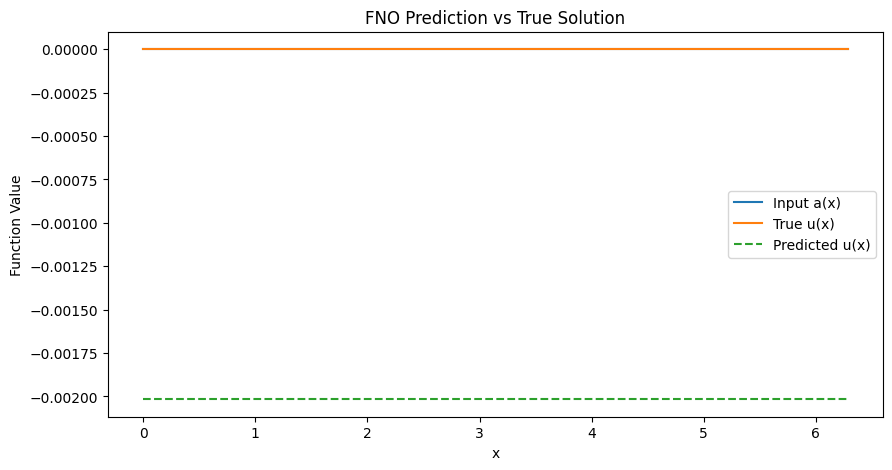

In [ ]:
# Main execution
if __name__ == "__main__":
    # Parameters
    n_samples = 100  # Number of training samples
    n_points = 128   # Number of grid points
    modes = 16       # Number of Fourier modes
    width = 32       # Number of channels
    n_epochs = 100   # Number of training epochs
    
    # Generate data
    inputs, outputs, x = generate_data(n_samples, n_points)
    
    # Initialize model
    model = FNO1D(modes=modes, width=width)
    
    # Train model
    train_fno(model, inputs, outputs, n_epochs)
    
    # Step 6: Test and visualize
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        test_input = inputs[0:1]  # Take one sample for visualization
        test_output = outputs[0:1]
        pred = model(test_input)
        
        # Plot results
        plt.figure(figsize=(10, 5))
        x_list    = x.squeeze().detach().cpu().tolist()
        ain_list  = test_input.squeeze().detach().cpu().tolist()
        true_list = test_output.squeeze().detach().cpu().tolist()
        pred_list = pred.squeeze().detach().cpu().tolist()

        plt.plot(x_list, ain_list,  label='Input a(x)')
        plt.plot(x_list, true_list, label='True u(x)')
        plt.plot(x_list, pred_list, '--', label='Predicted u(x)')

        plt.legend()
        plt.title('FNO Prediction vs True Solution')
        plt.xlabel('x')
        plt.ylabel('Function Value')
        plt.show()